In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import pydicom
import numpy as np
import os
import glob
from tqdm import tqdm
import warnings
import pandas as pd
DATA_PATH = '/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/'
WORKING_DIR = '/kaggle/input/rsna-2024-train/'
DATASET_SELECTION = 'axial'

In [2]:
train_candidates = pd.read_csv(WORKING_DIR+'train_candidates.csv')

In [3]:
train_candidates[train_candidates['study_id']==1085426528].groupby(['series_id','series_description']).size()

series_id   series_description
211738165   Sagittal T2/STIR       5
1518511736  Sagittal T1           10
2303722192  Axial T2              10
dtype: int64

In [4]:
from collections import namedtuple
import functools
import datetime
from torch.utils.data import Dataset
import random
import pickle

SEVERITY_MAPPING = {"Normal/Mild":0,"Moderate":1,"Severe":2}
SEVERITY_WEIGHTING = {0:1.0,1:2.0,2:4.0}

## Dataset

Classification Component Set:
- candidate_list: list of instances with bounding box coordinates *(need to adjust for image boundaries)* 
- sorted_study_ids: the list of study_ids sorted with respect to condition severity, used for creating robust validation sets

In [6]:
# Initialise candidate_info_tuple
candidate_info_tuple = namedtuple(
    'candidate_info_tuple',
    'row_id, study_id, series_id, instance_number, has_centres, centre_xy, severity, img_path, width_bbox, height_bbox'
)

# Read in relevant Classification Component Set
with open(f'/kaggle/input/rsna-2024-train-candidate-list/candidate_list_{DATASET_SELECTION}.pkl', 'rb') as f:
    out = pickle.load(f)
    
candidate_list, sorted_study_ids = out['candidate_list'],out['sorted_study_ids']


In [29]:
@functools.lru_cache(1, typed=True)
def get_image(path):
    return pydicom.dcmread(path)

In [30]:
# Pass img_path which is mutable and can be easily cached, get_image() is also cached
# and so this should not result in additional compute
@functools.lru_cache(1, typed=True)
def get_roi(img_path, x_centre, y_centre, width = 50, height = 40):
    image = get_image(img_path)
    y_max, x_max = image.pixel_array.shape
    x_left, x_right, y_bot, y_top = int(max(0,x_centre - width//2)), int(min(x_max, x_centre + width//2)), int(max(0, y_centre - height//2)), int(min(y_max, y_centre + height//2))
    roi = image.pixel_array[y_bot:y_top,x_left:x_right]
    return roi.astype(np.uint8)

### Summaries

In [31]:
# pd.set_option('display.max_colwidth', None)

In [32]:
# temp = train_candidates[(train_candidates['series_description']=='Sagittal T1') & 
#                  (train_candidates['condition'].isin(["left_neural_foraminal_narrowing","right_neural_foraminal_narrowing"]))
#                 ].copy()

# def get_meta(df=temp):
#     df.loc[:,'ImagePositionPatient'] = None
#     df.loc[:,'left_or_right'] = None
        
#     for ndx, instance in enumerate(df.itertuples()):
#         if ndx%1000==0:
#                 print(f"{datetime.datetime.now()}, {ndx} records processed out of {len(df)}")
#         dicom = get_image(f"{instance.folder_path}/{instance.series_id}/{int(instance.instance_number)}.dcm")
#         df.at[instance.Index,'ImagePositionPatient'] = dicom.ImagePositionPatient
#         df.at[instance.Index,"left_or_right"] = "left" if dicom.ImagePositionPatient[0] > 0 else "right"

# get_meta(temp)

### Plot images

In [33]:
def dicom_transforms(img: np.array):
    IMG_normalized = cv2.normalize(img, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    # Convert the image from BGR to RGB for correct color display in matplotlib
    IMG_normalized = cv2.cvtColor(IMG_normalized, cv2.COLOR_BGR2RGB)
    return IMG_normalized

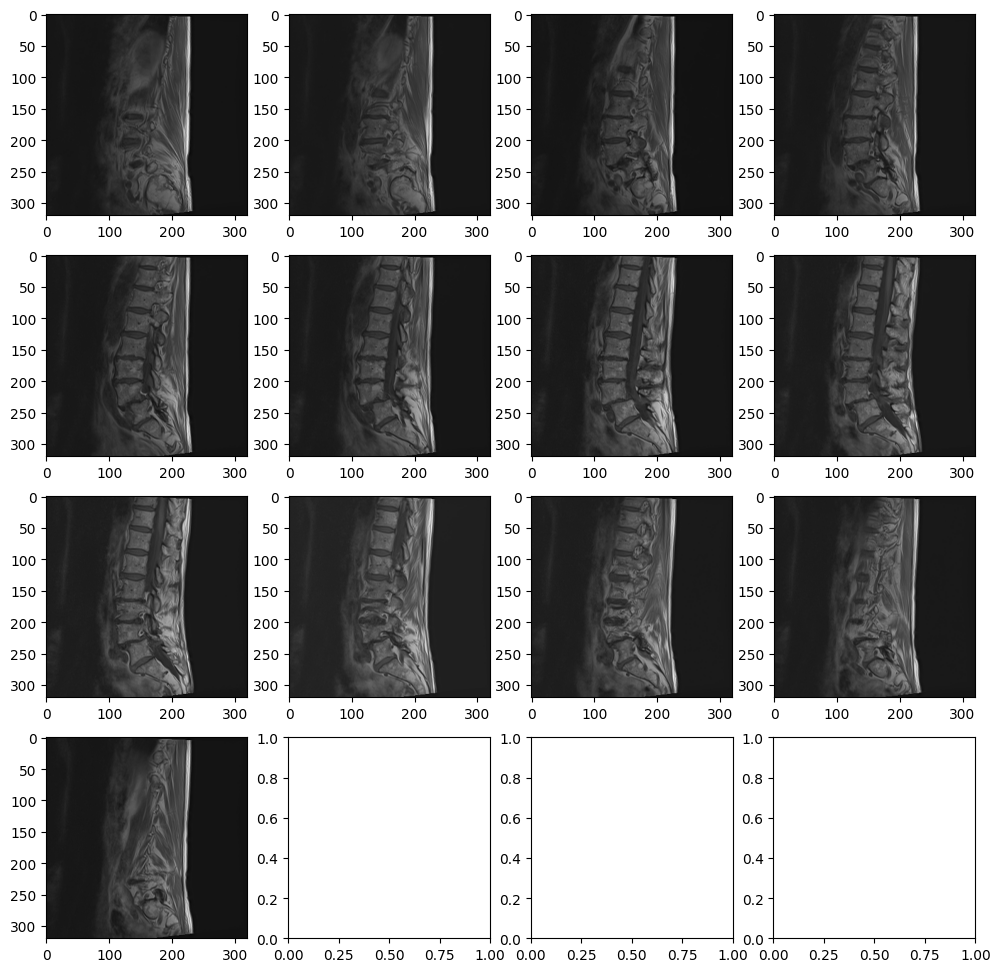

In [34]:
import matplotlib.pyplot as plt
import cv2
import os
import glob
import math
import re

# Function to extract the numeric values from the filename
def extract_numbers(file_path):
    filename = file_path.split('/')[-1]
    numbers = re.findall(r'\d+', filename)
    return list(map(int, numbers))


def plot_images(image_dir,pattern="*"):
    """
    Plot YOLO predictions and ground truth labels on images.

    Parameters:
    - image_dir (str): Directory containing the images.
    - label_dir (str): Directory containing the label files.
    - model: YOLO model for making predictions.
    - pattern (str): Pattern to match image files in the directory.
    """
    # Get list of images
    image_paths = sorted(glob.glob(os.path.join(image_dir, pattern)),key=extract_numbers)
    
    # Plot image with ground truth and predicted boxes
    num_rows = math.ceil(len(image_paths)/4)
    fig, ax = plt.subplots(num_rows, 4, figsize=(12, 12))      
    
    if num_rows > 1:
        ax = ax.flatten()
    else:
        ax = [ax]  # Make it iterable for consistency    
    
    imgs = []
    for i, image_path in enumerate(image_paths):
        # Load image
        img = get_image(image_path)
        imgs.append(img)
        IMG = img.pixel_array
        IMG_normalized = cv2.normalize(IMG, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
        # Convert the image from BGR to RGB for correct color display in matplotlib
        IMG_normalized = cv2.cvtColor(IMG_normalized, cv2.COLOR_BGR2RGB)
        
        ax[i].imshow(IMG_normalized)
        
    # Show the result
    plt.show()
        
    return imgs
        
# Example usage:
out = plot_images(image_dir="/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/",
           pattern="1085426528/1518511736/*")


### Dataset

In [35]:
class LumbarSeverityDataset(Dataset):
    
    def __init__(self,
                val_stride=0,
                val_set=False,
                study_id=None,
                candidate_list=None,
                transform=None,
                sample: int | None = None,
                rand_bbox: bool = False,
                sorted_candidate_list=None, 
                save_to_drive: bool = False,
                debug_mode: bool = False):
        
        self.sample = sample
        self.rand_bbox = rand_bbox
        self.save_to_drive = save_to_drive
        self.debug_mode = debug_mode
        self.val_set = val_set
        
        if candidate_list:
            self.candidate_list = candidate_list
        else:
            raise Exception("Must provide candidate_list.")
        
        # Default to a stratified sampled of candidates by study_id (option to provide custom sorted list on other
        # stratifications).
        if sorted_candidate_list:
            self.sorted_candidate_list = sorted_candidate_list.copy()
        else:
            study_ids = np.unique([str(x.study_id) for x in self.candidate_list])
            self.sorted_candidate_list = np.random.shuffle(study_ids)
        
        if study_id:
            self.candidate_list = [x for x in self.candidate_list if str(x.study_id) == study_id]
        
        if self.val_set:
            assert val_stride > 0, val_stride
            val_study_ids = self.sorted_candidate_list[::val_stride]
            self.candidate_list = [x for x in self.candidate_list if str(x.study_id) in val_study_ids]
            assert self.candidate_list
        elif val_stride > 0:
            del self.sorted_candidate_list[::val_stride]                        
            self.candidate_list = [x for x in self.candidate_list if str(x.study_id) in self.sorted_candidate_list]            
            assert self.candidate_list
    
        self.transform = transform
    
    def __len__(self):
        if self.sample:
            return min(self.sample, len(self.candidate_list))
        else:
            return len(self.candidate_list)
    
    def __getitem__(self,ndx):
        """
        return 
        """
        
        candidate = self.candidate_list[ndx]
        
        if self.rand_bbox:    
            width = randint(40,60)
            height = randint(50,70)
            candidate = self.candidate_list[ndx]._replace(width_bbox = width, height_bbox=height)
            self.candidate_list[ndx] = candidate
#         # Get full image
#         image = get_image(candidate.img_path)

        roi = get_roi(candidate.img_path, candidate.centre_xy[0], candidate.centre_xy[1],candidate.width_bbox, candidate.height_bbox)
    
        if self.transform:
            try:
                roi = self.transform(roi)        
            except Exception as e:
                print(f"Exception raised for {candidate.row_id} \n\n {e}")                
        
        return roi, candidate.severity, candidate.row_id, candidate
        
    def get_items_by_study(self, study_id):
        """
        Get items for a specific study.
        """
        study_candidates = [i for i, x in enumerate(self.candidate_list) if x.study_id == study_id]
        result = [self.__getitem__(i) for i in study_candidates]

        return result        

    def get_items_by_row_id(self, row_id, debug=False):
        """
        Get items for a specific study.
        """
        study_candidates = [i for i, x in enumerate(self.candidate_list) if x.row_id == row_id]
        if debug:
            try:
                result = [self.__getitem__(i) for i in study_candidates]
            except Exception:
                return get_roi(candidate.img_path, candidate.centre_xy[0], candidate.centre_xy[1],candidate.width_bbox, candidate.height_bbox), candidate
        else:
            result = [self.__getitem__(i) for i in study_candidates]

        return result     

In [60]:
dataset = LumbarSeverityDataset(candidate_list=candidate_list)

In [61]:
dataset = LumbarSeverityDataset(candidate_list=candidate_list,study_id='870699023')

In [62]:
img_data = [i for i in dataset if i[2]=='870699023_1241187576_left_subarticular_stenosis_l3_l4'][0][0]

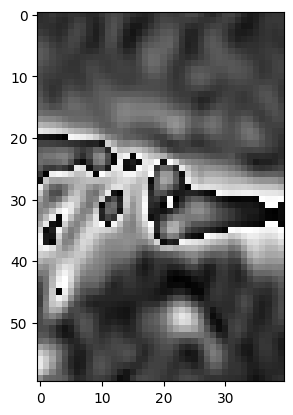

In [63]:
plt.imshow(img_data, cmap='gray')

### Training code

- Efficient net: 1 x model for all image types 

In [17]:
import torch
from torch import nn
from PIL import Image
from torchvision import models
from torchvision.transforms import transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import v2

# Define a custom transform to convert to RGB
class ToRGB(object):
    def __call__(self, img):
        if isinstance(img, np.ndarray):
            # Convert NumPy array to PIL Image
            img = Image.fromarray(img)
        # Convert the image to RGB mode
        img_rgb = img.convert('RGB')
        return img_rgb

# For ImageNet pretrained
transform = v2.Compose([
    ToRGB(), # Custom transform to convert to RGB
    v2.Resize(255),
    v2.CenterCrop(240),
    v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)]), # replaces ToTensor()
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

augment = v2.Compose([
        v2.RandomApply(
            [
                v2.RandomAffine(
                    degrees=(-20, 20), translate=(0.0,0.25), scale=(0.75, 1)
                ),
            ],
            p=0.5,
        ),
        v2.RandomHorizontalFlip(p=0.5)
])


In [65]:
transform = v2.Compose([transform,augment])

In [70]:
dataset.get_items_by_row_id("870699023_1241187576_left_subarticular_stenosis_l3_l4")

[(array([[ 45,  49,  56, ...,  52,  55,  54],
         [ 46,  48,  51, ...,  55,  57,  57],
         [ 50,  49,  46, ...,  54,  53,  55],
         ...,
         [234, 199, 153, ...,  42,  40,  38],
         [203, 169, 128, ...,  38,  38,  40],
         [140, 105, 101, ...,  37,  45,  48]], dtype=uint8),
  0,
  '870699023_1241187576_left_subarticular_stenosis_l3_l4',
  candidate_info_tuple(row_id='870699023_1241187576_left_subarticular_stenosis_l3_l4', study_id='870699023', series_id='1241187576', instance_number=25.0, has_centres=True, centre_xy=(304.81767699780573, 361.9977356164399), severity=0, img_path='/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification//train_images/870699023/1241187576/25.dcm', width_bbox=40, height_bbox=60))]

In [71]:
def plot_subplot(images):
    # Calculate the grid size based on the number of images
    n_images = len(images)
    cols = int(np.ceil(np.sqrt(n_images)))
    rows = int(np.ceil(n_images / cols))

    # Create subplots
    fig, axs = plt.subplots(rows, cols, figsize=(10, 10))

    # If there's only one row or column, axs might not be a 2D array, so we ensure it's always 2D
    if rows == 1:
        axs = np.expand_dims(axs, 0)
    if cols == 1:
        axs = np.expand_dims(axs, 1)

    # Loop through the images and plot them
    for i, image in enumerate(images):
        row, col = divmod(i, cols)
        axs[row, col].imshow(image, cmap='gray')
        axs[row, col].set_title(f'Image {i + 1}')
        axs[row, col].axis('off')

    # Remove empty subplots if any
    for j in range(i + 1, rows * cols):
        row, col = divmod(j, cols)
        fig.delaxes(axs[row, col])

    # Adjust layout
    plt.tight_layout()

    # Display the plot
    plt.show()

In [72]:
train_dataset = LumbarSeverityDataset(candidate_list=candidate_list, 
                                      sorted_candidate_list=sorted_study_ids, 
                                      transform=transform)  # Example usage

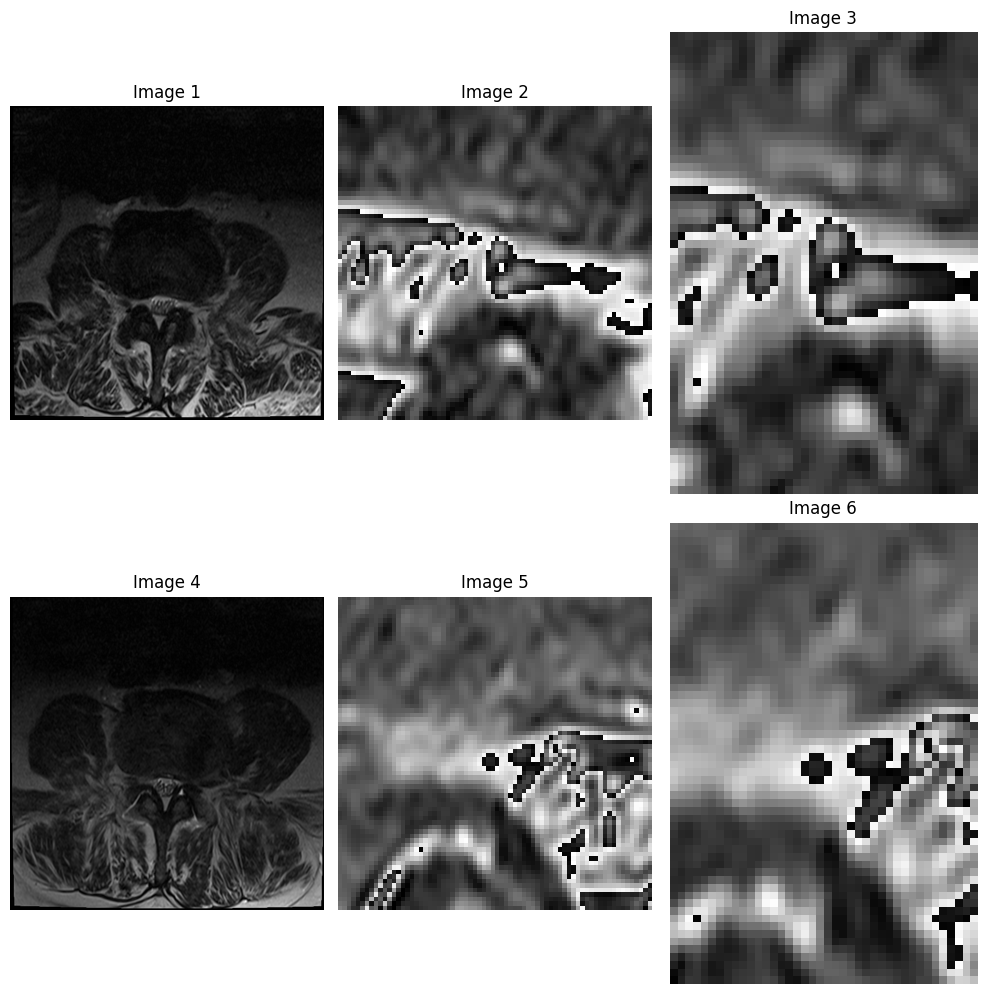

In [73]:
# get_image(path)
image_list = []
candidate = train_dataset.get_items_by_row_id("870699023_1241187576_left_subarticular_stenosis_l3_l4")[0][3]
img = dicom_transforms(get_image(candidate.img_path).pixel_array)
roi = get_roi(candidate.img_path, candidate.centre_xy[0], candidate.centre_xy[1],70, 70)
roi_ = get_roi(candidate.img_path, candidate.centre_xy[0], candidate.centre_xy[1],candidate.width_bbox, candidate.height_bbox)
image_list.extend([img,roi,roi_])

candidate = train_dataset.get_items_by_row_id("870699023_1241187576_right_subarticular_stenosis_l4_l5")[0][3]
img = dicom_transforms(get_image(candidate.img_path).pixel_array)
roi = get_roi(candidate.img_path, candidate.centre_xy[0], candidate.centre_xy[1],70, 70)
roi_ = get_roi(candidate.img_path, candidate.centre_xy[0], candidate.centre_xy[1],candidate.width_bbox, candidate.height_bbox)

image_list.extend([img,roi,roi_])


plot_subplot(image_list)

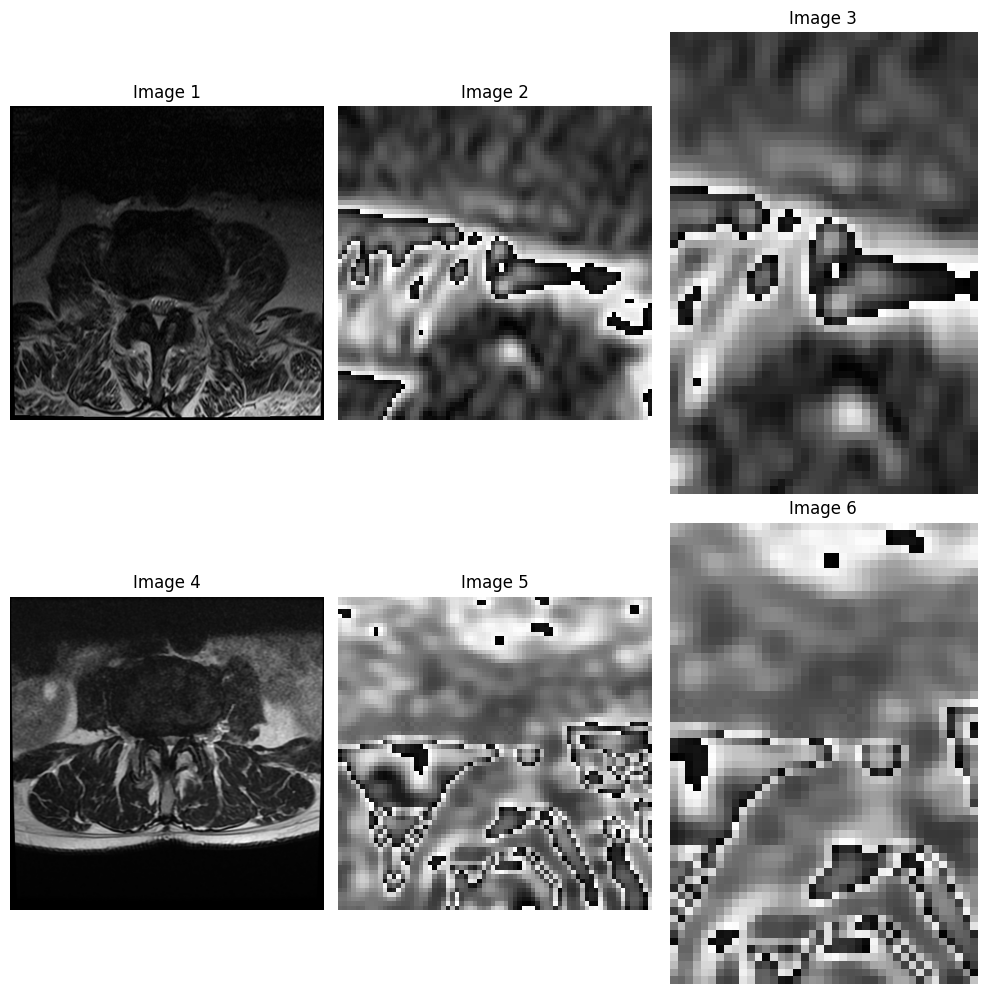

In [74]:
# get_image(path)
image_list = []
candidate = train_dataset.get_items_by_row_id("870699023_1241187576_left_subarticular_stenosis_l3_l4")[0][3]
img = dicom_transforms(get_image(candidate.img_path).pixel_array)
roi = get_roi(candidate.img_path, candidate.centre_xy[0], candidate.centre_xy[1],70, 70)
roi_ = get_roi(candidate.img_path, candidate.centre_xy[0], candidate.centre_xy[1],candidate.width_bbox, candidate.height_bbox)
image_list.extend([img,roi,roi_])

candidate = train_dataset.get_items_by_row_id("96439573_1359869694_left_subarticular_stenosis_l3_l4")[0][3]
img = dicom_transforms(get_image(candidate.img_path).pixel_array)
roi = get_roi(candidate.img_path, candidate.centre_xy[0], candidate.centre_xy[1],70, 70)
roi_ = get_roi(candidate.img_path, candidate.centre_xy[0], candidate.centre_xy[1],candidate.width_bbox, candidate.height_bbox)

image_list.extend([img,roi,roi_])


plot_subplot(image_list)

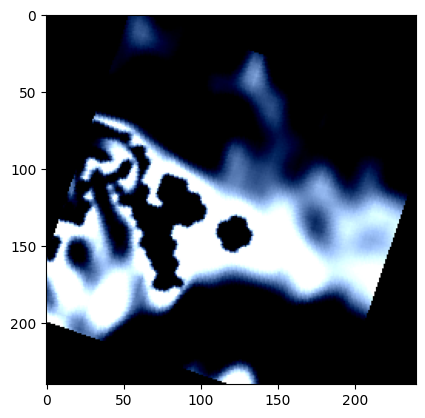

In [77]:
img = train_dataset.get_items_by_row_id("870699023_1241187576_right_subarticular_stenosis_l4_l5")[0][0]
plt.imshow(img.permute(1,2,0),cmap='gray')

## Model building

#### Config

In [11]:
class Config:
    def __init__(self):
        # Training parameters
        self.batch_size = 32
        self.learning_rate = 5e-4
        self.num_epochs = 20
        self.trained_epochs = None
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        
        # Dataset
        self.roi_width_range = (40,60)
        self.roi_height_range = (50,70)
        
        # Model parameters
        self.model_type = 'resnet50.a1_in1k'
        self.pretrained = True
        self.num_classes = 3
        self.fc = 'fc'
        self.trainable_layers = ['layer4']
        
        # Optimization parameters
        self.optimizer = 'adam'
        self.weight_decay = 1e-4
        self.momentum = 0.9
        
        # Scheduler parameters
        self.use_scheduler = True
        self.scheduler = 'cosine_annealing'
        self.T_max = 50
        
        # Early stopping
        self.early_stop = True
        self.early_stop_patience = 5
        
        # Mixed precision training
        self.use_amp = True
        self.clip_grad = True
        self.clip_value = 1.0
        
        # Augmentation
        self.horizontal_flip = 0.5
        self.random_affine = True
        
        # Logging parameters
        self.log_interval = 10
        self.tensorboard_log_dir = './logs'
        
    def update(self, **kwargs):
        """ Update configuration parameters. """
        for key, value in kwargs.items():
            if hasattr(self, key):
                setattr(self, key, value)
            else:
                raise AttributeError(f"{key} is not a valid attribute of Config")
        return self  # Return the entire Config object
                
    def get(self,value: str, default: any = Ellipsis):
        if hasattr(self,value):
            return getattr(self,value)
        else:
            if default is Ellipsis:
                raise ValueError(f"Attribute '{value}' does not exist and no default value was provided.")
            return default


# Example usage
config = Config()

# # Update parameters if needed
# config.update(batch_size=64, learning_rate=0.0005, num_epochs=100)


#### Utils

In [12]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

### Timm

In [19]:
import timm 

len(timm.list_models())

1063

In [81]:
model = timm.create_model(
    'resnet50.a1_in1k',
    pretrained=True,
#     num_classes=0,  # remove classifier nn.Linear
)

In [82]:
model = timm.create_model(
    "efficientnet_b3.ra2_in1k",
    pretrained=True)

In [83]:
data_config = timm.data.resolve_model_data_config(model)
transform = timm.data.create_transform(**data_config, is_training=False)


In [84]:
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)

In [20]:
# Example model definition (same as before)
class LumbarNet(nn.Module):
    def __init__(self, config: dict):
        super(LumbarNet, self).__init__()
        
        self.config = config
        
        pretrained = config.get("pretrained")
        model_type = config.get("model_type")
        self.model = timm.create_model(model_type,pretrained) # keep linear head for in_features

        # Set trainable layers
        trainable_layers = config.get('trainable_layers',[])        
        if trainable_layers:
            self.set_layer_requires_grad(trainable_layers)
        else:
            self.freeze_all(self.model)

        # Set fully connected
        fc = config.get('fc',None)
        if fc:
            out = getattr(self.model, fc)
            in_f = out.in_features
            new_fc = nn.Linear(in_f, config.get('num_classes'))
            setattr(self.model, fc, new_fc)
        
    def forward(self, x):
        return self.model(x)
    
    @staticmethod
    def freeze_all(model):
        for param in model.parameters():
            param.requires_grad = False
            
    def set_layer_requires_grad(self, layers_to_unfreeze):
        # Freeze all layers first
        self.freeze_all(self.model)

        # Unfreeze the specified layers
        for layer_name in layers_to_unfreeze:
            layer = getattr(self.model, layer_name, None)
            if layer and not isinstance(layer, nn.BatchNorm2d):
                for param in layer.parameters():
                    param.requires_grad = True
                

config = Config()
config.update(trainable_layers=None)
model = LumbarNet(config)

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

In [86]:
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
all_params = sum(p.numel() for p in model.parameters())

trainable_params, all_params

(6147, 23514179)

In [23]:
def get_standard_transforms(model: nn.Module):
    """
    Only applied if pretrained=True.
    
    Removes CentreCrop which is likely to hinder performance when ROI are small enough anyway.
    """
    data_config = timm.data.resolve_model_data_config(model)
    transform_list = timm.data.create_transform(**data_config, is_training=False)

    filtered_transforms = [t for t in transform_list.transforms if not isinstance(t, transforms.CenterCrop)]

    return filtered_transforms

In [24]:
def get_transforms(config: dict, model: nn.Module):
    
    transforms_list = []
    
    inference_transforms =  [ToRGB(),
             transforms.Resize(size=(256,256), interpolation=transforms.InterpolationMode.BICUBIC, max_size=None),
             transforms.ToTensor(),
             transforms.Normalize(mean=torch.tensor([0.4850, 0.4560, 0.4060]), std=torch.tensor([0.2290, 0.2240, 0.2250]))]
        
    if config.get("pretrained",False):

        transforms_list.extend(inference_transforms)
        
    else:
        # TODO standard minmax transforms to dataset
        transforms_list.append(ToRGB())


    if config.get("horizontal_flip", False):
        transforms_list.append(v2.RandomHorizontalFlip(p=config.get("horizontal_flip")))
    
    if config.get("random_affine", False):
        transforms_list.append(v2.RandomApply([
                v2.RandomAffine(
                    degrees=(-20, 20), translate=(0.0,0.25), scale=(0.75, 1)
                )],p=0.25))
            
            
    composed_transforms = transforms.Compose(transforms_list)
    
    return composed_transforms, transforms.Compose(inference_transforms)

In [25]:
get_transforms(config,model)

(Compose(
     Resize(size=(256, 256), interpolation=bicubic, max_size=None, antialias=warn)
     ToTensor()
     Normalize(mean=tensor([0.4850, 0.4560, 0.4060]), std=tensor([0.2290, 0.2240, 0.2250]))
     RandomHorizontalFlip(p=0.5)
     RandomApply(    RandomAffine(degrees=[-20.0, 20.0], translate=(0.0, 0.25), scale=(0.75, 1), interpolation=InterpolationMode.NEAREST, fill=0))
 ),
 Compose(
     Resize(size=(256, 256), interpolation=bicubic, max_size=None, antialias=warn)
     ToTensor()
     Normalize(mean=tensor([0.4850, 0.4560, 0.4060]), std=tensor([0.2290, 0.2240, 0.2250]))
 ))

In [92]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from torch.utils.tensorboard import SummaryWriter
from copy import deepcopy
import datetime
from kaggle_secrets import UserSecretsClient
from torch.cuda.amp import GradScaler, autocast
from torch.optim.lr_scheduler import CosineAnnealingLR
import os 

# Training function
def train(model, dataloader, criterion, optimizer, scheduler, device, scaler, use_amp, clip_grad, clip_value):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for ndx, batch in enumerate(dataloader):
        if ndx % 200 == 0:
            print(f"{datetime.datetime.now()} Train: completed {ndx}/{len(dataloader)} batches.")
        inputs, labels, ids, _ = batch
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()        
        
        with autocast(enabled=config.get("use_amp")):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
        
        if scaler is not None:
            scaler.scale(loss).backward()
            if clip_grad:
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)
                
            scaler.step(optimizer)
            scaler.update()
        else:
            loss.backward()
            if clip_grad:
                torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)
            optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    
    if scheduler is not None:
        scheduler.step()
        
    return running_loss / len(dataloader), correct / total

# Validation function
def validate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in dataloader:
            inputs, labels, ids, _ = batch
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    return running_loss / len(dataloader), correct / total

def main(model, tensorboard_flag=False):
    model_dir = "/kaggle/working/severity_classification/"

    if not os.path.exists(model_dir):
        os.makedirs(model_dir)
    
    # Saving attributes
    run_id = config.get("run_id",datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))

    log_dir = "/kaggle/working/tensorboard_logs"
    # Initialize TensorBoard
    if tensorboard_flag:
        writer = SummaryWriter(log_dir=log_dir)    
    
    # Hyperparameters
    val_best_loss = float('inf')
    patience = 2
    epochs = config.get("epochs",20)
    batch_size = config.get("batch_size",32)
    learning_rate = config.get("learning_rate",1e-4)
    
    if config.get("early_stop",False):
        early_stopper = EarlyStopper(config.get("early_stop_patience",3))
    
    transform, inference_transform = get_transforms(config, model)
    
    # Create the dataset and data loader
    train_dataset = LumbarSeverityDataset(candidate_list=candidate_list, 
                                          sorted_candidate_list=sorted_study_ids, 
#                                           val_stride=4, 
                                          transform=transform, 
#                                           val_set=False
                                         )  # Example usage
    val_dataset = LumbarSeverityDataset(candidate_list=candidate_list, 
                                        sorted_candidate_list=sorted_study_ids, 
                                        val_stride=4, 
                                        transform=inference_transform, 
                                        val_set=True)  # Example usage
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    # Model, criterion, optimizer
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    weights = torch.tensor(list(SEVERITY_WEIGHTING.values())).to(device)
    criterion = nn.CrossEntropyLoss(weight=weights)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Initialize the scheduler
    if config.get('use_scheduler'):
        scheduler = CosineAnnealingLR(optimizer, T_max=config.get('T_max'))

    # Initialize AMP scaler
    if config.get('use_amp'):
        scaler = GradScaler()
    
    # Training loop
    for epoch in range(epochs):
        train_loss, train_accuracy = train(
        model, 
        train_loader, 
        criterion, 
        optimizer, 
        scheduler if config.get('use_scheduler',False) else None, 
        device, 
        scaler if config.get('use_amp',False) else None, 
        use_amp = config.get('use_amp',False), 
        clip_grad = config.get('clip_grad'), 
        clip_value = config.get('clip_value')
    )
        val_loss, val_accuracy = validate(model, val_loader, criterion, device)

        print(f"Epoch [{epoch + 1}/{epochs}] Train Loss: {train_loss:.4f} Train Acc: {train_accuracy:.4f} Val Loss: {val_loss:.4f} Val Acc: {val_accuracy:.4f}")
        
        if epoch > patience and val_best_loss > val_loss:
            val_best_loss = val_loss
            config.update(trained_epochs=epoch)
            best_model_state = {"model":model.state_dict(),"config": config}
            torch.save(best_model_state, f"/kaggle/working/severity_classification/{config.model_type}_{run_id}.pth")

        if config.get("early_stop",False):
            if early_stopper.early_stop(val_loss):   
                config.update(trained_epochs=epoch)
                best_model_state = {"model":model.state_dict(),"config": config}
                torch.save(best_model_state, f"/kaggle/working/severity_classification/{config.model_type}_{run_id}_earlystop.pth")                        
                break
                        
        if tensorboard_flag:
            # Log metrics to TensorBoard
            writer.add_scalar('Loss/train', train_loss, epoch)
            writer.add_scalar('Accuracy/train', train_accuracy, epoch)
            writer.add_scalar('Loss/val', val_loss, epoch)
            writer.add_scalar('Accuracy/val', val_accuracy, epoch)

    if tensorboard_flag:
        # Close the TensorBoard writer
        writer.close()


In [ ]:
config = Config()
config.update(trainable_layers=['layer2','layer3','layer4'])
model = LumbarNet(config)
tensorboard_flag = True
main(model, tensorboard_flag)

In [ ]:
config = Config()
config.update(trainable_layers=['layer1','layer2','layer3','layer4'])
model = LumbarNet(config)
tensorboard_flag = True
main(model, tensorboard_flag)

## Evaluation

In [ ]:
import torch
import torch.nn.functional as F
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, roc_auc_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

class ModelEvaluator:
    def __init__(self, model, val_loader, criterion, device):
        self.model = model
        self.val_loader = val_loader
        self.criterion = criterion
        self.device = device
    
    def evaluate(self):
        """
        Evaluates the model on the validation set.
        Returns the collected results, average loss, and accuracy.
        """
        self.model.eval()
        running_loss = 0.0
        correct = 0
        total = 0
        results = []

        with torch.no_grad():
            for batch in self.val_loader:
                inputs, labels, ids, _ = batch
                inputs, labels = inputs.to(self.device), labels.to(self.device)

                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)

                probs = F.softmax(outputs, dim=1)

                running_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

                # Collect the outputs, labels, and ids
                results.extend(zip(ids, labels.cpu(), probs.cpu()))

        avg_loss = running_loss / len(self.val_loader)
        accuracy = correct / total
        
        # Store results in a DataFrame
        self.df = pd.DataFrame(results, columns=['id', 'label', 'output'])
        self.df['label'] = self.df['label'].apply(lambda x: x.item())
        # Ensure the output column has the predicted class
        self.df['predicted'] = self.df['output'].apply(lambda x: np.argmax(x.numpy()))
        
        return self.df, avg_loss, accuracy

        def compute_grouped_accuracy(self, *group_by_columns):
            """
            Computes accuracy and value counts per group defined by the group_by_columns.

            Parameters:
                df (pd.DataFrame): DataFrame containing 'label' and 'output' columns.
                *group_by_columns (str): Columns to group by.

            Returns:
                pd.DataFrame: A DataFrame with group keys, accuracy, and value counts for each group.
                
            Example:
                grouped_accuracy_df = compute_grouped_accuracy(df, 'id', 'some_other_column')

            """
            df = self.df
            
            # Group by the specified columns
            grouped = df.groupby(list(group_by_columns))

            # Compute accuracy and value counts for each group
            results = []
            for group, data in grouped:
                correct = (data['label'] == data['predicted']).sum()
                total = len(data)
                accuracy = correct / total
                value_counts = total

                results.append({
                    **{col: val for col, val in zip(group_by_columns, group)},
                    'accuracy': accuracy,
                    'value_counts': value_counts
                })

            # Convert results to a DataFrame
            results_df = pd.DataFrame(results)
            return results_df    
    
    def compute_and_plot_confusion_matrix(self, filter_by=None, filter_value=None, pretty_print=False, class_names=None):
        df = self.df
        if filter_by and filter_value:
            df = df[df[filter_by] == filter_value]

        y_true = df['label'].values
        y_pred = df['predicted'].values

        cm = confusion_matrix(y_true, y_pred)

        if pretty_print:
            plt.figure(figsize=(5, 5))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
            plt.xlabel('Predicted')
            plt.ylabel('True')
            plt.title('Confusion Matrix')
            plt.show()

        return cm
    
    def compute_auc(self):
        y_true = self.df['label'].values
        y_prob = np.stack(self.df['output'].apply(lambda x: x.numpy()))  # Convert list of tensors to a 2D array

        return roc_auc_score(y_true, y_prob, average='macro', multi_class='ovr')
    
    def compute_f1_score(self):
        y_true = self.df['label'].values
        y_pred = self.df['output'].apply(lambda x: np.argmax(x.numpy())).values
        
        return f1_score(y_true, y_pred, average='weighted')

In [21]:
import pickle
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_selection = "/kaggle/input/severity-classification/pytorch/resnet-axial/1/resnet50.a1_in1k_2024-10-30_11-29-34_earlystop.pth" if DATASET_SELECTION == 'axial' else  "/kaggle/input/severity-classification/pytorch/resnet-sagittal-t1/1/resnet50.a1_in1k_2024-089_13-24-01_earlystop.pth"

best_model_state = torch.load(model_selection,
                             map_location = device)
config = Config()
model = LumbarNet(config)
model.load_state_dict(best_model_state['model'])


<All keys matched successfully>

In [36]:
# Usage Example:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

_, transform = get_transforms(config,model)

val_dataset = LumbarSeverityDataset(candidate_list=candidate_list, 
                                    sorted_candidate_list=sorted_study_ids, 
                                    val_stride=4, 
                                    transform=transform, 
                                    val_set=True)
val_loader = DataLoader(val_dataset, batch_size=16)

weights = torch.tensor(list(SEVERITY_WEIGHTING.values())).to(device)
criterion = nn.CrossEntropyLoss(weight=weights)

evaluator = ModelEvaluator(model, val_loader, criterion, device)
results_df, avg_loss, accuracy = evaluator.evaluate()

In [37]:
cm = evaluator.compute_and_plot_confusion_matrix()
auc = evaluator.compute_auc()
f1 = evaluator.compute_f1_score()

print("Confusion Matrix:\n", cm)
print("AUC:", auc)
print("F1 Score:", f1)
print("Average Loss:", avg_loss)
print("Accuracy:", accuracy)

Confusion Matrix:
 [[2985  421   24]
 [ 273  529  113]
 [  44  175  242]]
AUC: 0.8793015536544863
F1 Score: 0.7869171286719205
Average Loss: 1.0304634867613498
Accuracy: 0.7815230961298377
